In [1]:
import pandas as pd
import random
import numpy as np
from matplotlib import pylab as plt
import scipy.stats
import copy
from scipy.sparse import linalg as LA
#import powerlaw
# %matplotlib inline

path_data = "../data/"
path_fig = "../results/fig/"

In [2]:
#The following have been removed
# df_2019[(df_2019['OCC2010']!= 9999) & (df_2019["LABFORCE"] == 2) & (df_2019['CPSIDP']!= 0)]
#PAN not na
df_2019 = pd.read_pickle(path_data + "CPS_df_occmobpanel_2019_asec.pkl")
df_asec = pd.read_pickle(path_data + "CPS_asec_df_occmob_summary_2019.pkl")

### Make ordered list of occupations with broad category
List and broad category taken from here https://usa.ipums.org/usa-action/variables/OCC2010#codes_section
(Extraction merged with contruction and technicians with Arch & Eng, Military removed)

In [3]:
df_categories = pd.read_csv(path_data + "occ2010_cps_broad_class.csv")
occ_cps = set(df_2019["OCC2010"].unique())
occ_cps_form = set(df_categories["Code"])

In [4]:
print("Check that all OCC2010 codes in cps 2019 are in the list", occ_cps.difference(occ_cps_form))
print("Remove from list those codes that are not in cps 2019", occ_cps_form.difference(occ_cps))
to_remove = occ_cps_form.difference(occ_cps)
df_categories = df_categories[~df_categories['Code'].isin(to_remove)]

Check that all OCC2010 codes in cps 2019 are in the list set()
Remove from list those codes that are not in cps 2019 {320, 9920, 9800, 8060, 1980, 9230, 1230, 3120, 9810, 8340, 7125, 8150, 7960, 7930, 9820, 6430}


In [5]:
df_categories.to_csv(path_data + "occ2010_in_cps2019.csv", index=False)
df_categories = pd.read_csv(path_data + "occ2010_in_cps2019.csv")
df_categories.head()
occ_names = list(df_categories["Label"])
occ_codes = list(df_categories["Code"])
dict_code_index = {}
for i in range(len(occ_codes)):
    dict_code_index[occ_codes[i]] = i

In [6]:
df_categories.head()

,Code,BroadClassification,Label
0,10,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",Chief executives and legislators/public admini...
1,20,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",General and Operations Managers
2,30,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers in Marketing, Advertising, and Public..."
3,100,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",Administrative Services Managers
4,110,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS",Computer and Information Systems Managers


In [7]:
len(df_categories)

442

### Calculate labor force 2019 CPS

In [7]:
df_2019.head()

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,MISH,ASECOVERH,...,EMPSAME,ASECOVERP,LNKFW1MWT,LNKFWMIS45WT,LNKFWMIS14WT,LNKFWMIS58WT,PANLWT,OCCLY,OCC10LY,QOCCLY
34206660,2019,1,1,1821.1212,20181200000100,NaN,NaN,NaN,2,NaN,...,2.0,NaN,1988.3906,0.0000,0.0,0.0000,2638.8811,NaN,NaN,NaN
34206662,2019,3,1,1804.2193,20171200000300,NaN,NaN,NaN,6,NaN,...,2.0,NaN,1969.9362,0.0000,0.0,0.0000,2614.3895,NaN,NaN,NaN
34206663,2019,5,1,3296.9061,20190100000500,NaN,NaN,NaN,5,NaN,...,99.0,NaN,3673.7676,0.0000,0.0,3746.7128,0.0000,NaN,NaN,NaN
34206666,2019,5,1,3296.9061,20190100000500,NaN,NaN,NaN,5,NaN,...,99.0,NaN,4275.2050,0.0000,0.0,5051.0948,0.0000,NaN,NaN,NaN
34206668,2019,7,1,2673.3924,20181000000200,NaN,NaN,NaN,4,NaN,...,2.0,NaN,0.0000,6049.5465,0.0,0.0000,3873.8579,NaN,NaN,NaN


In [8]:
person_sample_counts = df_2019['CPSIDP'].value_counts()
sampled_twice = list(person_sample_counts[person_sample_counts >1].index)
# only consider people sampled twice
df_2019 = df_2019[df_2019['CPSIDP'].isin(sampled_twice)] 

df_2019['Idx'] = df_2019.index
# NOTE sorting is essential for the algorithm to calculate occupational mobility
df_2019 = df_2019.sort_values(by = ['CPSIDP', 'Idx'])

In [9]:
print( "Labor force Feb 2019 using WTFINL (million workers)", df_2019["WTFINL"][df_2019["MONTH"] == 2].sum()/1e6)
print( "Labor force Feb 2019 using PANLWT (million workers)", df_2019["PANLWT"][df_2019["MONTH"] == 2].sum()/1e6)
print( "Labor force Feb 2019 using LNKFW1MWT (million workers)", df_2019["LNKFW1MWT"][df_2019["MONTH"] == 2].sum()/1e6)
# print( "Labor force Feb 2019 using PANLWT (million workers)", df_2019["PANLWT"][df_2019["MONTH"] == 2].sum()/1e6)

Labor force Feb 2019 using WTFINL (million workers) 155.5769617594
Labor force Feb 2019 using PANLWT (million workers) 158.9182299814
Labor force Feb 2019 using LNKFW1MWT (million workers) 120.37632375550002


In [10]:
print( "Labor force March 2019 using WTFINL (million workers)", df_2019["WTFINL"][df_2019["MONTH"] == 3].sum()/1e6)
print( "Labor force March 2019 using PANLWT (million workers)", df_2019["PANLWT"][df_2019["MONTH"] == 3].sum()/1e6)
print( "Labor force March 2019 using LNKFW1MWT (million workers)", df_2019["LNKFW1MWT"][df_2019["MONTH"] == 3].sum()/1e6)
# print( "Labor force Feb 2019 using PANLWT (million workers)", df_2019["PANLWT"][df_2019["MONTH"] == 2].sum()/1e6)

Labor force March 2019 using WTFINL (million workers) 156.9201581556
Labor force March 2019 using PANLWT (million workers) 159.5386710184
Labor force March 2019 using LNKFW1MWT (million workers) 120.2513840439


### Calculate labor force 2019 ASEC

In [11]:
df_asec = df_asec[df_asec["ASECWT"].notna()]
# remove CPSIDP unless they are part of the asec over sample
df_asec = df_asec[(df_asec["CPSIDP"] != 0) | (df_asec["ASECOVERP"] == 1)] 

# # In case sorting is needed for later, but probably not
# # add index in case useful
# df_asec['Idx'] = df_asec.index
# df_asec = df_asec.sort_values(by = ['CPSIDP', 'Idx'])

In [12]:
print( "Labor force March 2019 using ASECWT (million workers)", df_asec["ASECWT"].sum()/1e6)

Labor force March 2019 using ASECWT (million workers) 163.00103038999998


#### To do: of the people that switched occupationn how many did in their current job and how many in other job. How about ASEC. Use EMPSAME

## Occupation transitions

### ASEC

In [13]:
df_asec.head()

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,HFLAG,CPSIDP,ASECWT,AGE,SEX,...,EMPSTAT,LABFORCE,OCC,OCC2010,IND,EMPSAME,ASECOVERP,OCCLY,OCC10LY,QOCCLY
34564987,2019,4,3,20180302857800,1.0,NaN,20180302857801,2031.67,21,1,...,10,2,4050,4050,8660,NaN,0.0,4050.0,4050.0,0.0
34564989,2019,7,3,20190302846800,1.0,NaN,20190302846801,1209.17,61,2,...,10,2,4020,4000,8660,NaN,0.0,4020.0,4000.0,0.0
34564991,2019,8,3,20190302822300,1.0,NaN,20190302822302,1480.79,37,1,...,10,2,4610,4610,8370,NaN,0.0,4610.0,4610.0,0.0
34564993,2019,15,3,20190202831700,1.0,NaN,20190202831701,1583.31,53,2,...,10,2,4840,4840,6290,NaN,0.0,4840.0,4840.0,0.0
34564997,2019,21,3,20180102883800,1.0,NaN,20180102883801,1502.27,54,1,...,10,2,6420,6420,770,NaN,0.0,6420.0,6420.0,0.0


In [14]:
df_asec["ChangeOcc"] = df_asec["OCC2010"] != df_asec["OCC10LY"]
df_asec["ChangeOccWT"] = df_asec["ChangeOcc"] * df_asec["ASECWT"]

In [15]:
print("Workforce estimation (millions) ", df_asec["ASECWT"].sum()/1e6)
print("People that changed occupaiton (millions) ", df_asec["ChangeOccWT"].sum()/1e6)
print("Percentage of workforce that switched occupation in a year ", df_asec["ChangeOccWT"].sum()/df_asec["ASECWT"].sum())

Workforce estimation (millions)  163.00103038999998
People that changed occupaiton (millions)  25.82486389
Percentage of workforce that switched occupation in a year  0.15843374626657783


### CPS

In [16]:
def calculate_transitions_cps(df):
    """ Function that calculates occupation\industry transitions
    Args:
        df(DaraFrame): dataframe with cps _sorted_ by cpsid
    NOTE df must be sorted!
    """
    # setting id's to compare when a transition happens
    person_id_old, occ_old, ind_old = 0, 0, 0
    # counters for raw (i.e. not using person weights) transitions
    raw_transitions_occ, raw_transitions_ind, raw_transitions_both = 0, 0, 0
    # coutner for estimated transitions in the use population (using PANLWT)
    transitions_occ, transitions_ind, transitions_both = 0, 0, 0
    # counter for people remaining in same occ or industry
    remained_occ, remained_ind = 0, 0
    
    # iterate over rows (df is sorted by person id)
    for index, row in df.iterrows():
        person_id_new = row["CPSIDP"]
        # still same person as before
        if person_id_new == person_id_old:
            # check if person changed occupation
            if occ_old != row["OCC2010"]:
                # add transitions to counters
                raw_transitions_occ +=1 
                transitions_occ += 1 * row["PANLWT"]
                occ_old = row["OCC2010"]
                # check if person also changed industry
                if ind_old != row["IND"]:
                    raw_transitions_both += 1
                    transitions_both += 1 * row["PANLWT"]
            # if did not change occ add in remain
            else:
                remained_occ += 1 * row["PANLWT"]
                
            # check if person changed industry
            if ind_old != row["IND"]: 
                raw_transitions_ind += 1
                transitions_ind += 1 * row["PANLWT"]
            else:
                remained_ind += 1 * row["PANLWT"]
        # if it is not same person a before update id's
        else:
            person_id_old = person_id_new
            occ_old = row["OCC2010"]
            ind_old = row["IND"]
            
    
    return transitions_occ, transitions_ind, transitions_both, \
            raw_transitions_occ, raw_transitions_ind, raw_transitions_both, remained_occ, remained_ind
    

In [17]:
df_2019 = df_2019.sort_values(by = ['CPSIDP', 'Idx'])
df_2019 = df_2019[["YEAR", 'SERIAL', "MONTH", "CPSIDP", "MISH",'PANLWT', \
                  'OCC', 'OCC2010', 'IND', 'EMPSAME', 'ASECOVERP', 'OCCLY', 'OCC10LY', 'QOCCLY', 'Idx']]

In [18]:
transitions_occ, transitions_ind, transitions_both, \
    raw_transitions_occ, raw_transitions_ind, raw_transitions_both, remained_occ, remained_ind \
    = calculate_transitions_cps(df_2019)

In [19]:
print("Workforce estimation (millions) March", df_2019["PANLWT"][df_2019["MONTH"] == 3].sum()/1e6)
print("People that changed occupaiton (millions) Year", transitions_occ/1e6)
print("Percentage of workforce that switched occupation in a year", transitions_occ/ df_2019["PANLWT"][df_2019["MONTH"] == 3].sum())
print("Ratio between transitions and remains ", transitions_occ/(transitions_occ + remained_occ))

Workforce estimation (millions) March 159.5386710184
People that changed occupaiton (millions) Year 142.81815790919916
Percentage of workforce that switched occupation in a year 0.8951946070349774
Ratio between transitions and remains  0.08196651501138642


In [20]:
print("Workforce estimation (millions) March", df_2019["PANLWT"][df_2019["MONTH"] == 3].sum()/1e6)
print("People that changed industriesn (millions) Year", transitions_ind/1e6)
print("Percentage of workforce that switched oindustries in a year", transitions_ind/ df_2019["PANLWT"][df_2019["MONTH"] == 3].sum())
print("Ratio between transitions and remains ", transitions_ind/(transitions_ind + remained_ind))

Workforce estimation (millions) March 159.5386710184
People that changed industriesn (millions) Year 182.0927691368978
Percentage of workforce that switched oindustries in a year 1.1413707283289114
Ratio between transitions and remains  0.10450708728797503


In [21]:
df_2019_febmarch = df_2019[(df_2019["MONTH"] == 2) | (df_2019["MONTH"] == 3)]
df_2019_febmarch = df_2019_febmarch[["YEAR", 'SERIAL', "MONTH", "CPSIDP", "MISH",'PANLWT', \
                  'OCC', 'OCC2010', 'IND', 'EMPSAME', 'ASECOVERP', 'OCCLY', 'OCC10LY', 'QOCCLY']]
person_sample_counts = df_2019_febmarch['CPSIDP'].value_counts()
sampled_twice = list(person_sample_counts[person_sample_counts >1].index)
# only consider people sampled twice
df_2019_febmarch = df_2019_febmarch[df_2019_febmarch['CPSIDP'].isin(sampled_twice)] 

df_2019_febmarch['Idx'] = df_2019_febmarch.index
# NOTE sorting is essential for the algorithm to calculate occupational mobility
df_2019_febmarch = df_2019_febmarch.sort_values(by = ['CPSIDP', 'Idx'])

In [22]:
transitions_occ, transitions_ind, transitions_both, \
    raw_transitions_occ, raw_transitions_ind, raw_transitions_both, remained_occ, remained_ind \
    = calculate_transitions_cps(df_2019_febmarch)

In [23]:
print("People that changed occupaiton (millions) Month", transitions_occ/1e6)
print("Percentage of workforce that switched occupation in a Month", transitions_occ/ df_2019["PANLWT"][df_2019["MONTH"] == 3].sum())
print("Ratio between transitions and remains Month", transitions_occ/(transitions_occ + remained_occ))

People that changed occupaiton (millions) Month 11.926793017300012
Percentage of workforce that switched occupation in a Month 0.07475800657712928
Ratio between transitions and remains Month 0.07648601366376781


In [24]:
transitions_occ/1e6

11.926793017300012

In [25]:
transitions_occ/(transitions_occ + remained_occ)

0.07648601366376781

### CPS occ

In [26]:
df_2019.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'CPSIDP', 'MISH', 'PANLWT', 'OCC', 'OCC2010',
       'IND', 'EMPSAME', 'ASECOVERP', 'OCCLY', 'OCC10LY', 'QOCCLY', 'Idx'],
      dtype='object')

In [27]:
def calculate_transitions_cps_nonharmonized(df):
    """ Function that calculates occupation\industry transitions
    Args:
        df(DaraFrame): dataframe with cps _sorted_ by cpsid
    """
    # setting id's to compare when a transition happens
    person_id_old, occ_old, ind_old = 0, 0, 0
    # counters for raw (i.e. not using person weights) transitions
    raw_transitions_occ, raw_transitions_ind, raw_transitions_both = 0, 0, 0
    # coutner for estimated transitions in the use population (using PANLWT)
    transitions_occ, transitions_ind, transitions_both = 0, 0, 0
    # counter for people remaining in same occ or industry
    remained_occ, remained_ind = 0, 0
    
    # iterate over rows (df is sorted by person id)
    for index, row in df.iterrows():
        person_id_new = row["CPSIDP"]
        # still same person as before
        if person_id_new == person_id_old:
            # check if person changed occupation
            if occ_old != row["OCC"]:
                # add transitions to counters
                raw_transitions_occ +=1 
                transitions_occ += 1 * row["PANLWT"]
                occ_old = row["OCC"]
                # check if person also changed industry
                if ind_old != row["IND"]:
                    raw_transitions_both += 1
                    transitions_both += 1 * row["PANLWT"]
            # if did not change occ add in remain
            else:
                remained_occ += 1 * row["PANLWT"]
                
            # check if person changed industry
            if ind_old != row["IND"]: 
                raw_transitions_ind += 1
                transitions_ind += 1 * row["PANLWT"]
            else:
                remained_ind += 1 * row["PANLWT"]
        # if it is not same person a before update id's
        else:
            person_id_old = person_id_new
            occ_old = row["OCC"]
            ind_old = row["IND"]
            
    
    return transitions_occ, transitions_ind, transitions_both, \
            raw_transitions_occ, raw_transitions_ind, raw_transitions_both, remained_occ, remained_ind
    

In [22]:
df_2019 = df_2019.sort_values(by = ['CPSIDP', 'Idx'])
df_2019 = df_2019[["YEAR", 'SERIAL', "MONTH", "CPSIDP", "MISH",'PANLWT', \
                  'OCC', 'OCC2010', 'IND', 'EMPSAME', 'ASECOVERP', 'OCCLY', 'OCC10LY', 'QOCCLY', 'Idx']]

In [23]:
transitions_occ, transitions_ind, transitions_both, \
    raw_transitions_occ, raw_transitions_ind, raw_transitions_both, remained_occ, remained_ind \
    = calculate_transitions_cps_nonharmonized(df_2019)

In [24]:
print("Workforce estimation (millions) March", df_2019["PANLWT"][df_2019["MONTH"] == 3].sum()/1e6)
print("People that changed occupaiton (millions) Year", transitions_occ/1e6)
print("Percentage of workforce that switched occupation in a year", transitions_occ/ df_2019["PANLWT"][df_2019["MONTH"] == 3].sum())
print("Ratio between transitions and remains ", transitions_occ/(transitions_occ + remained_occ))

Workforce estimation (millions) March 159.5386710184
People that changed occupaiton (millions) Year 143.70079303189902
Percentage of workforce that switched occupation in a year 0.9007270282157838
Ratio between transitions and remains  0.08247307892520159


## Making the occupational mobility network

### ASEC

In [24]:
df_asec["ChangeOcc"] = df_asec["OCC2010"] != df_asec["OCC10LY"]
df_asec["ChangeOccWT"] = df_asec["ChangeOcc"] * df_asec["ASECWT"]

In [25]:
df_asec_nonan = df_asec[(df_asec["ASECWT"].notna()) & (df_asec["OCC2010"] != 9999) & (df_asec["OCC10LY"] != 9999)] 

In [26]:
def occ_mob_asec(df, dict_code_index):
    """Makes occupational mobiltiy network from ASEC
    """
    # make empty matrix
    n = len(dict_code_index)
    A = np.zeros([n, n])
    # fill whenver there is a transition
    for index, row in df.iterrows():
        if row["OCC2010"] != row["OCC10LY"]:
            i, j = dict_code_index[row["OCC10LY"]], dict_code_index[row["OCC2010"]]
            A[i, j] += row["ASECWT"] # consider ASEC weights
    
    return A

In [27]:
T_asec_2019 = occ_mob_asec(df_asec_nonan , dict_code_index)

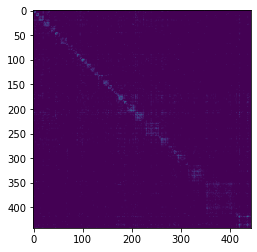

In [28]:
plt.imshow(np.sqrt(T_asec_2019))
plt.show()

<ipython-input-29-05d24c734c78>:1: RuntimeWarning: invalid value encountered in true_divide
  F_asec_2019 = T_asec_2019/T_asec_2019.sum(axis=1, keepdims=True)


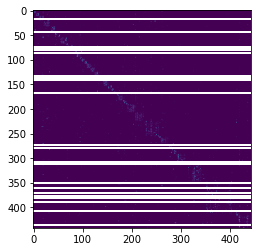

In [29]:
F_asec_2019 = T_asec_2019/T_asec_2019.sum(axis=1, keepdims=True)
plt.imshow(F_asec_2019)
plt.show()

### CPS

In [30]:
def occ_mob_cps(df, dict_code_index):
    """ Function that calculates occupation\industry transitions
    Args:
        df(DaraFrame): dataframe with cps SORTED by CPSIDP
    """
    # make empty matrix
    n = len(dict_code_index)
    A = np.zeros([n, n])
    # set id for old occupation
    occ_old = 0
    person_id_old= 0
    # iterate over rows (df is sorted by person id)
    for index, row in df.iterrows():
        person_id_new = row["CPSIDP"]
        # still same person as before
        if person_id_new == person_id_old:
            # check if person changed occupation
            if occ_old != row["OCC2010"]:
                i, j = dict_code_index[occ_old], dict_code_index[row["OCC2010"]]
                A[i, j] += row["PANLWT"]
            
        # if it is not same person a before update id's
        else:
            person_id_old = person_id_new
            occ_old = row["OCC2010"]

    return A

In [31]:
df_2019 = df_2019.sort_values(by = ['CPSIDP', 'Idx'])
T_cps_2019 = occ_mob_cps(df_2019 , dict_code_index)

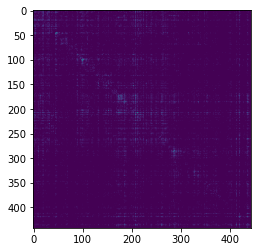

In [32]:
plt.imshow(np.sqrt(T_cps_2019))
plt.show()

<ipython-input-33-d39c3730b962>:1: RuntimeWarning: invalid value encountered in true_divide
  F_cps_2019 = T_cps_2019/T_cps_2019.sum(axis=1, keepdims=True)


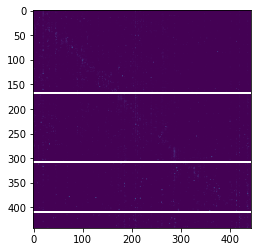

In [33]:
F_cps_2019 = T_cps_2019/T_cps_2019.sum(axis=1, keepdims=True)
plt.imshow(F_cps_2019)
plt.show()

In [34]:
df_2019.head()

,YEAR,SERIAL,MONTH,CPSIDP,MISH,PANLWT,OCC,OCC2010,IND,EMPSAME,ASECOVERP,OCCLY,OCC10LY,QOCCLY,Idx
34206682,2019,18,1,20171100002001,7,4486.5314,3500,3500,8090,99.0,NaN,NaN,NaN,NaN,34206682
34327490,2019,22,2,20171100002001,8,4020.0010,3500,3500,8090,99.0,NaN,NaN,NaN,NaN,34327490
34206683,2019,18,1,20171100002002,7,5431.0143,8140,8140,3680,2.0,NaN,NaN,NaN,NaN,34206683
34327491,2019,22,2,20171100002002,8,4640.4852,8140,8140,3680,2.0,NaN,NaN,NaN,NaN,34327491
34206686,2019,23,1,20171100002901,7,2661.4868,5120,5120,9590,99.0,NaN,NaN,NaN,NaN,34206686


In [35]:
df_2019["EMPSAME"].value_counts()

2.0     411878
99.0    241140
1.0       8874
96.0       133
97.0        85
Name: EMPSAME, dtype: int64

In [37]:
#df_2019["WTFINL"][df_2019["MONTH"] == 2].sum()